A typical use case is selection of solvent particles near a protein. Proteins can be treated as a group of atoms compressed in a form of sphere. Here, we consider a single protein at the centre of the simulation box  to compare PBC aware and non PBC data structures to evaluate the "around" selection.

The goal is to compare different shortlisted methods for this particular use case. The two types of data structures (hierarchical and grids) and naive brute frorce are used here. For linear grid data structures,  CellGrid ([here](https://github.com/MDAnalysis/cellgrid)) and Neighbour search implemented in FatsLiM([here](http://fatslim.github.io/)) are used. For hierarchical tree structures, Periodic KDtree implemented in MDAnalysis is used. Another tree structure, OCtree, which recursively divides a cuboid into its 8 children, is adopted from PointCloud library ([here](https://github.com/strawlab/python-pcl)). 

A similar benchmarks for single query are done for the same datastructures, which can be accesed from [here](https://github.com/ayushsuhane/Benchmarks_Distance/blob/master/Notebooks/OctreeComparison.ipynb). A variant of similar benchmarks are done by Jonathan ([here](https://github.com/jbarnoud/Benchmarks_Distance)) and Sébastian' ([here](https://github.com/seb-buch/Benchmarks_Distance/blob/master/Notebooks/CythonNS.ipynb) as well. This is an extension to multiple particles to check the scaling behaviour of build and query time for multiple selections and with different cutoff radius. 

In [12]:
import numpy as np
from cellgrid import capped_distance_array
from scipy.special import gammainc
from collections import defaultdict
import itertools

In [31]:
def generate_protein(center,radius,nparticles,box=None):
    """
    Generates set of particles distributed
    inside a sphere
    """
    r = radius
    ndim = center.size
    x = np.random.normal(size=(nparticles, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(nparticles,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p.astype('float32')

def generate_solvent(center,radius,nparticles,box):
    """
    Solvent particles are generated in the box uniformly
    except inside the sphere
    """
    points = np.random.uniform(low=0,high=1.0,size=(nparticles,3))*box[:3]
    idx = np.where(np.sum((points-center)**2,axis=1)<radius**2)
    points[idx] += np.sign(points[idx]-center)*radius
    return(points[np.where(np.sum((points-center)**2,axis=1)>radius**2)].astype('float32'))

# CellGrid

In [22]:
def cg_select(protein,solvent,maxdist,box):
    indx,dist = capped_distance_array(protein,solvent,maxdist,box[:3])
    mask = np.where(dist<maxdist)
    indices = (np.unique((indx[mask])[:,1]))
    return solvent[indices]

# Periodic KDtree

In [23]:
from MDAnalysis.lib.pkdtree import PeriodicKDTree
def kdtree_select(protein,solvent,maxdist,box):
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(solvent)
    kdtree.search(protein,maxdist)
    indices = kdtree.get_indices()
    return solvent[indices]

# Cython Neighbour Search - FATSLiM

In [24]:
from core_ns import FastNS
def ns_select(protein, solvent, maxdist, box):
    triclinic_box = np.array([[box[0], 0, 0],[0, box[1], 0],[0,0,box[2]]], dtype=np.float32)
    searcher = FastNS(triclinic_box)
    searcher.set_cutoff(maxdist)
    searcher.set_coords(solvent)
    searcher.prepare()
    results = []
    for coord in protein:
        res = searcher.search(np.array([coord,]))[0]
        if res.shape[0] != 0:
            results.append(res[0])
    if len(results) != 0:
        return np.unique(results, axis = 0)
    return
    

# Octree

In [25]:
import pcl
def oct_select(protein, solvent, maxdist, box):
    cloud = pcl.PointCloud(solvent)
    resolution = 0.2*box[0]
    octree = cloud.make_octreeSearch(resolution)
    octree.add_points_from_input_cloud()
    result = []
    for coord in protein: 
        [ind, sqdist] = octree.radius_search (coord, maxdist)
        if len(ind) != 0 :
            result.append(solvent[ind][0])
    if len(result) != 0:
        return np.unique(result, axis = 0) 
    
    return

# Brute Force

In [26]:
from MDAnalysis.lib.distances import distance_array
def bf_select(protein,solvent,maxdist,box):
    distance = distance_array(protein,solvent,box)
    mask = np.where(distance<maxdist)[1]
    return solvent[np.unique(mask)]

# Benchmarks

Total time to select solvent particles around a spherical protein using different methods is shown below.

For the first set, the scaling with number of solvent particles is shown. A radius of 6 units is chosen here for the purpose of demonstration. It is then followed by the variation of cutoff radius. 


In [8]:
#Initialize
box = np.array([100,100,100,90,90,90],dtype=np.float32)
center = box[:3]/2
radius = 10.0
maxdist = 6.0

In [16]:
from tqdm import tqdm_notebook
def timer(**params):
    Nprotein = params.get('Nprotein', None)
    Nsolvent = params.get('Nsolvent', None)
    maxdist = params.get('maxdist', None)
    centre = params.get('centre', None)
    radius = params.get('radius', None)
    protein = generate_protein(center,radius,Nprotein)
    results = defaultdict(list)
    
    for Nsolvent in tqdm_notebook(np.unique(Nsolvent)):
    
        solvent = generate_solvent(center, radius, Nsolvent, box)
        for cut in tqdm_notebook(np.unique(maxdist)):
            
            
            res = %timeit -q -o kdtree_select(protein, solvent, cut, box)
            results['kd'+'.'+str(cut)].append(res.average)
            
            res = %timeit -q -o ns_select(protein, solvent, cut, box)
            results['ns'+'.'+str(cut)].append(res.average)
            
            res = %timeit -q -o cg_select(protein, solvent, cut, box)
            results['cg'+'.'+str(cut)].append(res.average)
    
            res = %timeit -q -o bf_select(protein, solvent, cut, box)
            results['bf'+'.'+str(cut)].append(res.average)

            res = %timeit -q -o oct_select(protein, solvent, cut, box)
            results['oct'+'.'+str(cut)].append(res.average)
    
    return results

In [18]:
Nprotein = 100
Nsolvent = np.logspace(3 ,5 ,num = 6, dtype = np.int)
center = box[:3]/2
radius = 10.0
maxdist = 6.0

In [19]:
params = {
    'Nprotein':Nprotein,
    'Nsolvent':Nsolvent,
    'maxdist':maxdist,
    'centre':center,
    'radius':radius
         }

In [20]:
timing = timer(**params)

In [10]:
%matplotlib inline

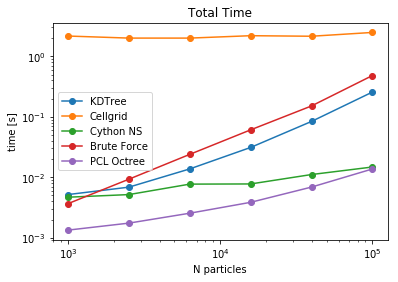

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
label = {'kd':"KDTree",
        'cg':"Cellgrid",
        'ns': "Cython NS",
        'bf': "Brute Force",
        'oct': "PCL Octree"}

for key in ['kd', 'cg', 'ns', 'bf', 'oct']:
    ax.plot(Nsolvent, timing[str(key)+'.'+str(maxdist)], '-o', label = label[key])
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total Time')
ax.legend()

For very low number of particles, brute force is a good method. However, if multiple selections are required, then it is not feasible to recalculate pair distance matrix again. Other option to store the pair distances as one of the triangular matrix is also not a good option, as the memory consumption increases with the number of particles. 

For lesser density of particles, while it looks like octree is a good option, but it is a non-periodic implementation. While, similar tweaks can be adapted from periodic KDtree implementation, the scaling cannot be predicted due to different traversing strategies in KDtree and Octree. In any case, it would be interesting to test an efficient periodic implementation of octree. For the range of number of particles generally considered in Molecular Dynamics, Neighbour search, definitely consumes less time as compared to periodic KDtree for fixed distance selections, also anticipated from single query benchmarks [here](https://github.com/ayushsuhane/Benchmarks_Distance/blob/master/Notebooks/OctreeComparison.ipynb).  

Another dimension is to test the execution time for different cutoff radius. Lets check the variation with cutoff radius for fixed number of particles as 40000.

In [11]:
Nprotein = 100
Nsolvent = 40000
center = box[:3]/2
radius = 10.0
maxdist = np.linspace(4, 10, num = 6, dtype = np.int)

In [12]:
params = {
    'Nprotein':Nprotein,
    'Nsolvent':Nsolvent,
    'maxdist':maxdist,
    'centre':center,
    'radius':radius
         }

In [13]:
timing = timer(**params)

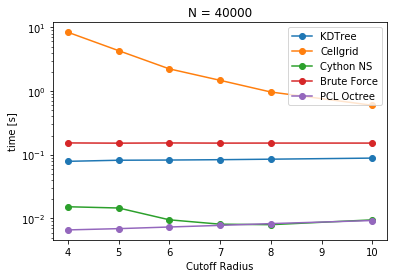

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
label = {'kd':"KDTree",
        'cg':"Cellgrid",
        'ns': "Cython NS",
        'bf': "Brute Force",
        'oct': "PCL Octree"}
result_cut = defaultdict(list)
for key in timing:
    method = key.split('.')[0]
    result_cut[method].append(timing[key])
    
for key in ['kd', 'cg', 'ns', 'bf', 'oct']:
    ax.plot(maxdist, result_cut[key], '-o', label = label[key])
ax.set(xlabel='Cutoff Radius', ylabel='time [s]', yscale='log', title='N = 40000')
ax.legend()

Except cellgrid, other methods dont scale with the cutoff radius to a large extent. However, neighbour search and Octree also scales with cutoff radius but with a very small slope. 

Below is the script which results in dead kernel. I suspected it might be due to consumption of memory, but it was not the case. 
Even the above script dies if I try to run for multiple cutoff distances, and/or particles. It definitely is not due to the number of particles, because I tried with less number of runs but large number of particles. I suspect it can be due to two reasons (1) Either handling of memory on my system is not so efficient (looks like there is a lot of clutter) on my system. (2) The more likely one, the kernel might be storing the data which I can't figure out to remove after executing all the methods for one setup (one instance of number of particles).

Another weird feature is the peak memory consumption. I am not sure if that is the culprit, but it could be.

In [7]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [8]:
Methods2 = dict(KDTree=kdtree_select, NS=ns_select, OCT=oct_select, BF=bf_select)

In [9]:
%memit Methods2

peak memory: 110.70 MiB, increment: 0.03 MiB


In [17]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
Nprotein = 100
Nsolvent = 1000
center = box[:3]/2
radius = 10.0
maxdist = 6.0

In [18]:
params = {
    'Nprotein':Nprotein,
    'Nsolvent':Nsolvent,
    'maxdist':maxdist,
    'centre':center,
    'radius':radius
         }

In [27]:
timing = %memit -q -o timer(**params)

In [28]:
timing

<MemitResult : peak memory: 2862.06 MiB, increment: 1379.27 MiB>

Such a high amount of memory is consumed when the number of particles are very less. I tried with different number of particles for different methods, this looks like a background memory consumption, but according to the docs it should be only depend on the memory usage by the function.

Everything below this is just for reference and to identify the problems I faced in this notebook.

In [29]:
Methods2 = dict(KDTree=kdtree_select, NS=ns_select, OCT=oct_select, BF=bf_select, CG=cg_select)

In [ ]:
from tqdm import tqdm_notebook

results, struct = defaultdict(list), defaultdict(list)
Nprotein = 100
Nsolvent = np.logspace(3 ,5 ,num = 6, dtype = np.int)
protein = generate_protein(center,radius,Nprotein)

for N in tqdm_notebook(np.unique(Nsolvent)):
    #Initialize
    struct = defaultdict(list)
    solvent = generate_solvent(center, radius, N, box)
    print("Number of Points:", N)
    
    
    for key, functions in Methods.items():
        struct[str(key)] = functions(protein, solvent, maxdist, box)
        res = %timeit -q -o functions(protein, solvent, maxdist, box)
        results[str(key)].append(res.average)
        del res
    results['N'].append(N)
    # Testing
    for a, b in itertools.combinations([struct[str(key)] for key in Methods], 2):
        if (a is not None) and (b is not None):
            np.testing.assert_equal(a.sort(axis = 0),b.sort(axis = 0))
        else:
            np.testing.assert_equal(a,b)
    del struct
    print("ALL TESTS PASSED")


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for key in Methods:
    ax.plot(results['N'], results[key], '-o', label = key)
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Total Time')
ax.legend()

For selection purposes, brute force is better at lower particle density upto around 1000 particles. Total time for non-periodic Octree also seems promising, however, its behaviour with PBC  is unknown. Neighbour search in FATSlim scales pretty well with number of particles, where it has a significant advantage for large number of particles. 

Although the trend can be easily extended from the single query benchmarks. But for the sake of completeness, lets check if there is any unexpected variation for selection with different cutoff radius. 

In [9]:
Methods2 = dict(KDTree=kdtree_select, NS=ns_select, OCT=oct_select, BF=bf_select)

In [14]:
box = np.array([100,100,100,90,90,90],dtype=np.float32)
center = box[:3]/2
radius = 10.0
maxdist = np.linspace(4, 10, num = 3, dtype = np.float32)
Nprotein = 100
Nsolvent = np.array([1000])
protein = generate_protein(center,radius,Nprotein)

In [2]:
%load_ext memory_profiler

In [15]:
def timer(method, protein, solvent, cut, box):
    res = %timeit -q -o method(protein, solvent, cut, box)
    return res.average
def memory(method, protein, solvent, cut, box):
    res = %memit -q -o method(protein, solvent, cut, box)
    return res.mem_usage[0]

In [16]:
from tqdm import tqdm_notebook
results2, struct2 = defaultdict(list), defaultdict(list)
for N in tqdm_notebook(np.unique(Nsolvent)):
    #Initialize
    solvent = generate_solvent(center, radius, N, box)
    print("Number of Points:", N)
    results2['N'].append(N)
    for cut in tqdm_notebook(np.unique(maxdist)):
        
        for key in Methods2:
            print(key)
            results2[str(key)+'.'+str(N)].append(timer(Methods2[key], protein, solvent, cut, box))
            results2['mem'+str(key)+'.'+str(N)].append(memory(Methods2[key], protein, solvent, cut, box))
            del Methods2[key]

Number of Points: 1000


KDTree
NS
OCT
BF
KDTree
NS
OCT
BF
KDTree
NS
OCT
BF



In [17]:
%memit -q -o Methods2

<MemitResult : peak memory: 5441.15 MiB, increment: 0.00 MiB>

In [19]:
results2

defaultdict(list,
            {'N': [1000],
             'KDTree.1000': [0.004731408571429451,
              0.005371267142857375,
              0.007642431428570749],
             'memKDTree.1000': [113.30859375, 5314.88671875, 5291.15234375],
             'NS.1000': [0.013609149999999447,
              0.005241251428573637,
              0.0028423099999989585],
             'memNS.1000': [5313.96484375, 5290.31640625, 5440.2578125],
             'OCT.1000': [0.0011210305714287512,
              0.0015515371428578614,
              0.002058074285714611],
             'memOCT.1000': [5314.0859375, 5290.31640625, 5440.26171875],
             'BF.1000': [0.0036874957142845233,
              0.0042731114285730395,
              0.0038277171428580913],
             'memBF.1000': [5314.88671875, 5291.15234375, 5441.078125]})

IndexError: index 1 is out of bounds for axis 0 with size 1

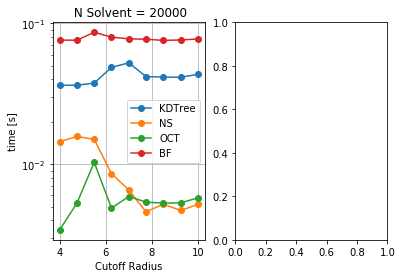

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols = 2,)

for i in range(len(axes)):
    ax = axes[i]
    N = Nsolvent[i]
    for key in Methods2:
        ax.plot(maxdist, results2[str(key)+'.'+str(N)], '-o', label = key)
    ax.set(xlabel='Cutoff Radius', ylabel='time [s]', yscale='log', title=' N Solvent = {}'.format(N))
    ax.legend()
    ax.grid(True)